In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import scipy
from scipy import ndimage, misc
import cv2
import os
from pathlib import Path
from IPython.display import HTML, display
from moviepy.editor import VideoFileClip

In [2]:
cwd = os.getcwd()

In [3]:
data_dir = cwd + '/test_images'

In [4]:
img_dir = [str(filePath) for filePath in Path(data_dir).glob("?.jpg") if filePath.is_file()]
img_dir.sort(key=lambda l: l[-5])

In [5]:
img_list = [plt.imread(d) for d in img_dir]

In [6]:
def plot(img_list, figsize=(12,6), title=None, title_loc=None, title_list=[], cm=None):
    fig,ax = plt.subplots(figsize=figsize, sharex=True)
    plt.axis('off')
    for i in range(len(img_list)):
        ax = fig.add_subplot(len(img_list)/2, 2, i + 1)
        plt.imshow(img_list[i], cmap=cm)
        plt.xticks([])
        plt.yticks([])
        if len(title_list) > 0:
            plt.xlabel(title_list[i])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    if title:
        plt.text(title_loc[0], title_loc[1], title, fontweight='bold', fontsize=12)
    plt.show()

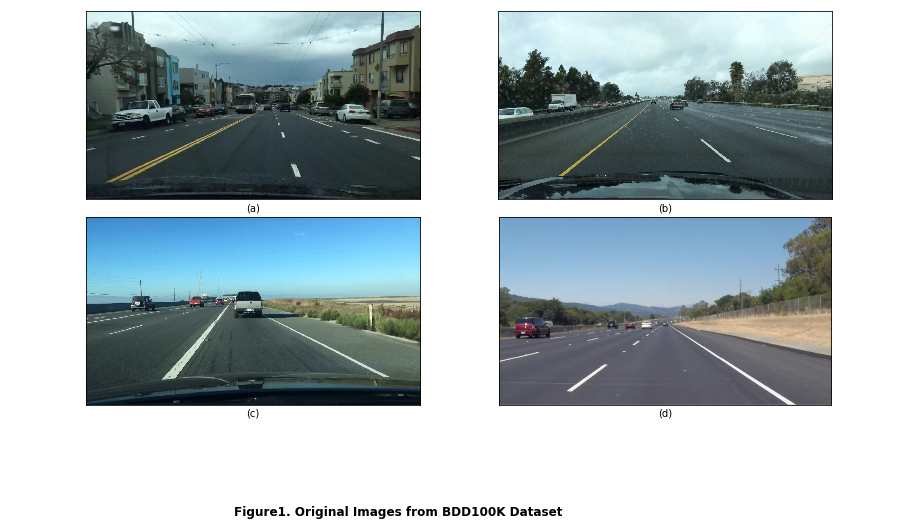

In [7]:
title = 'Figure1. Original Images from BDD100K Dataset'
title_list = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)']
plot(img_list, figsize=(12,6), title=title, title_loc=(-800,900), title_list=title_list)


### gray scale

In [8]:
def gray_scale(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

In [9]:
img_gray_list = []
for img in img_list:
    img_gray = gray_scale(img)
    img_gray_list.append(img)
    img_gray_list.append(img_gray)

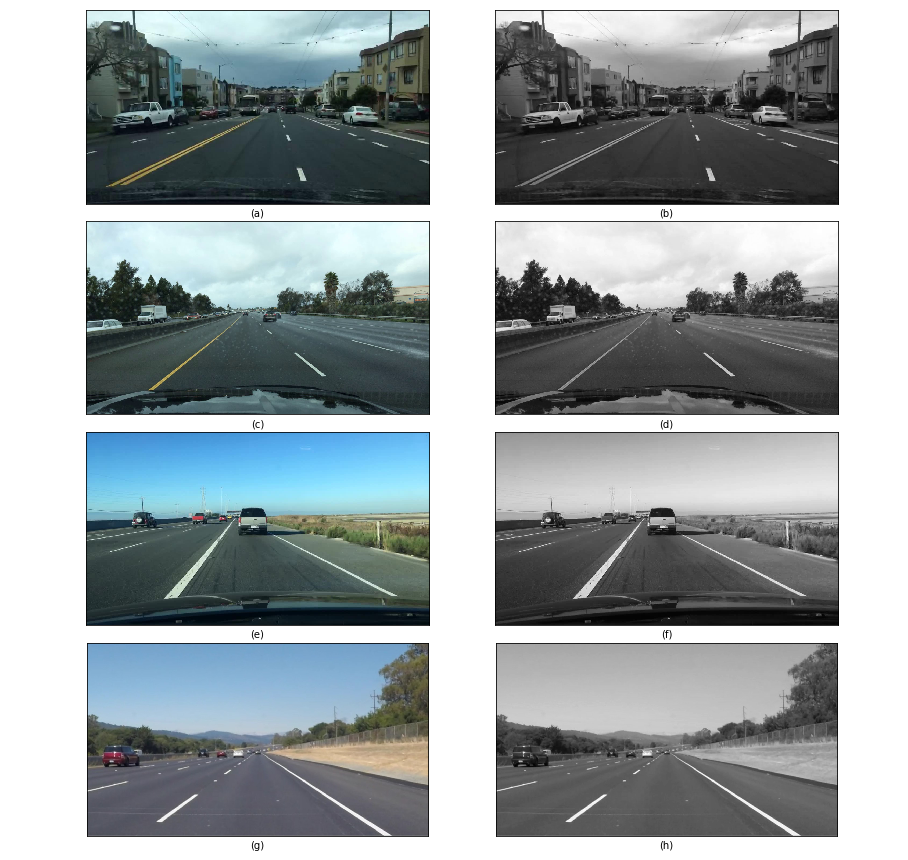

In [10]:
plot(img_gray_list, figsize=(12,12), title_loc=(-800,900), title_list=title_list, cm='gray')

### gaussian blur

In [11]:
def gaussian_blur(img, kernel_size, sigma):
    img_blur = cv2.GaussianBlur(img, kernel_size, sigma)
    return img_blur

In [12]:
kernel_size = (7,7)
sigma = 3

In [13]:
img_blur_list = []
for img in [img_gray_list[i] for i in range(len(img_gray_list)) if i%2==1]:
    img_blur = gaussian_blur(img, kernel_size, sigma)
    img_blur_list.append(img)
    img_blur_list.append(img_blur)

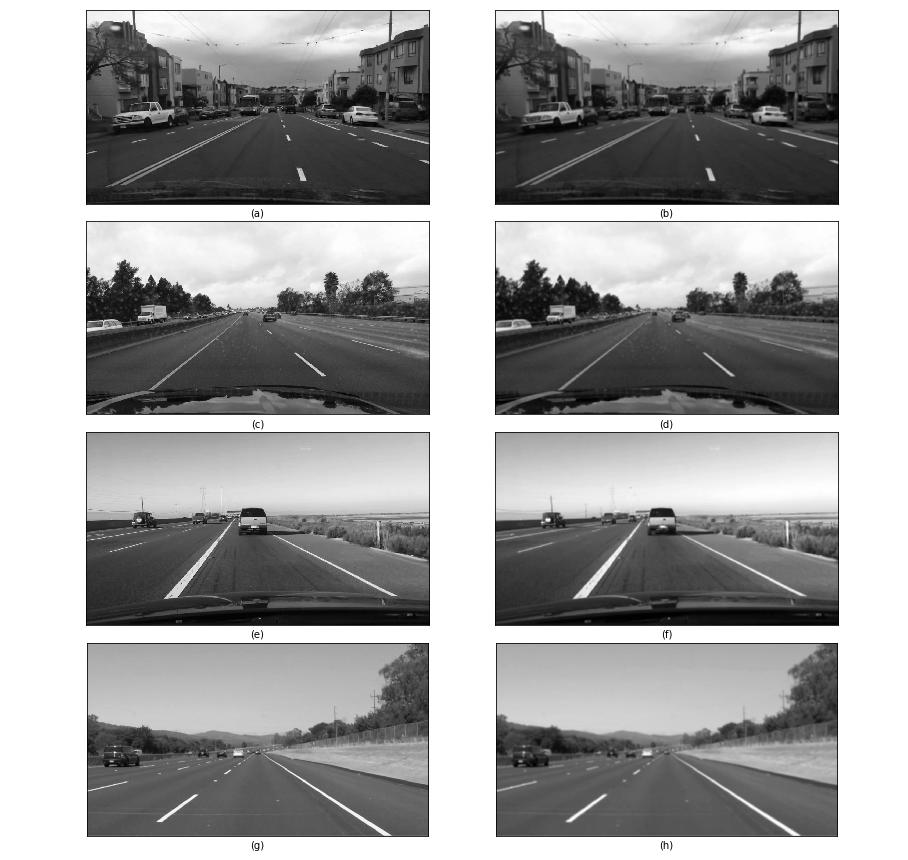

In [14]:
plot(img_blur_list, figsize=(12,12), title_loc=(-800,900), title_list=title_list, cm='gray')

### Canny Edge

In [15]:
def canny_edge(img, low_thred, high_thred):
    img_edge = cv2.Canny(img, low_thred, high_thred)
    return img_edge

In [16]:
low_thred = 30
high_thred = 90

In [17]:
img_canny_list = []
for img in [img_blur_list[i] for i in range(len(img_blur_list)) if i%2==1]:
    img_canny = canny_edge(img, low_thred, high_thred)
    img_canny_list.append(img)
    img_canny_list.append(img_canny)

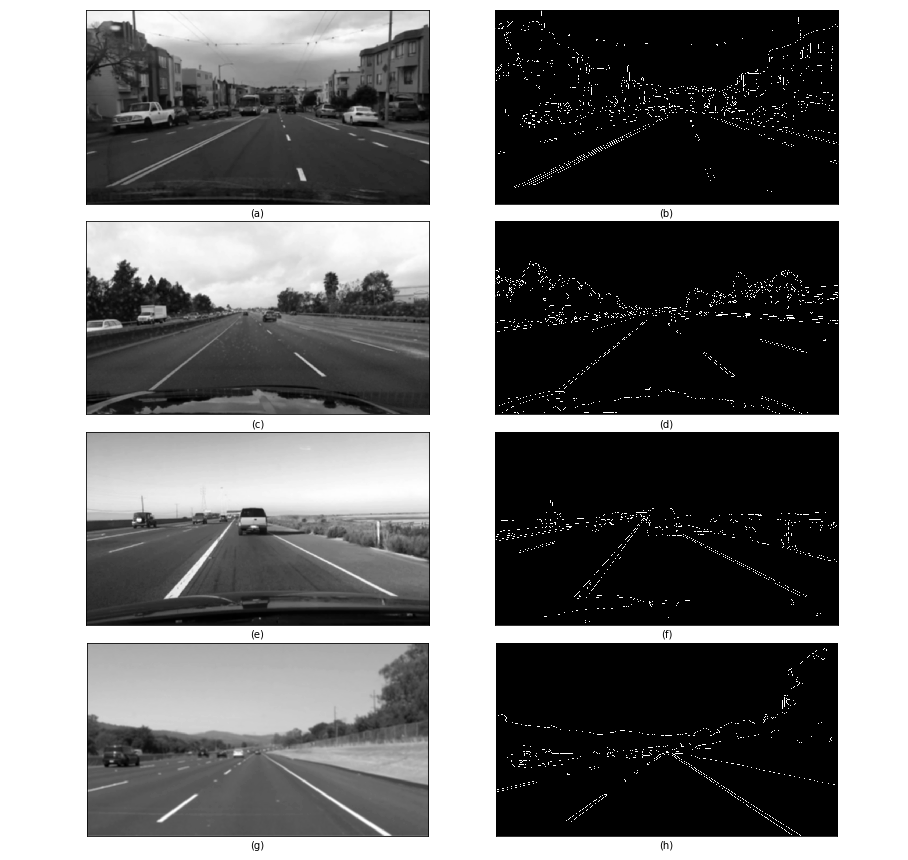

In [18]:
plot(img_canny_list, figsize=(12,12), title_loc=(-800,900), title_list=title_list, cm='gray')

### Line Segmentation

In [19]:
def filter_region(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    area = cv2.bitwise_and(img, mask)

    return area

In [20]:
def select_region(image, ratio_list):
    
    # first, define the polygon by vertices
    rows, cols = image.shape
    bottom_left  = [cols*ratio_list[0][0], rows*ratio_list[0][1]]
    top_left     = [cols*ratio_list[1][0], rows*ratio_list[1][1]]
    bottom_right = [cols*ratio_list[2][0], rows*ratio_list[2][1]]
    top_right    = [cols*ratio_list[3][0], rows*ratio_list[3][1]] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    
    return filter_region(image, vertices)

In [21]:
ratio1 = [(0.2,0.8),(0.45,0.55),(0.8,0.95),(0.6,0.55)]
ratio2 = [(0.1,0.85),(0.4,0.55),(0.75,0.85),(0.6,0.5)]
ratio3 = [(0.2,0.8),(0.35,0.5),(1,0.9),(0.55,0.55)]
ratio4 = [(0,1),(0.35,0.65),(0.95,1),(0.5,0.6)]
ratio_list = [ratio1, ratio2, ratio3, ratio4]

In [22]:
img_seg_list = []

for im, ratio in zip([img_canny_list[i] for i in range(len(img_canny_list)) if i%2==1], ratio_list):
    img_seg = select_region(im, ratio)
    img_seg_list.append(im)
    img_seg_list.append(img_seg)

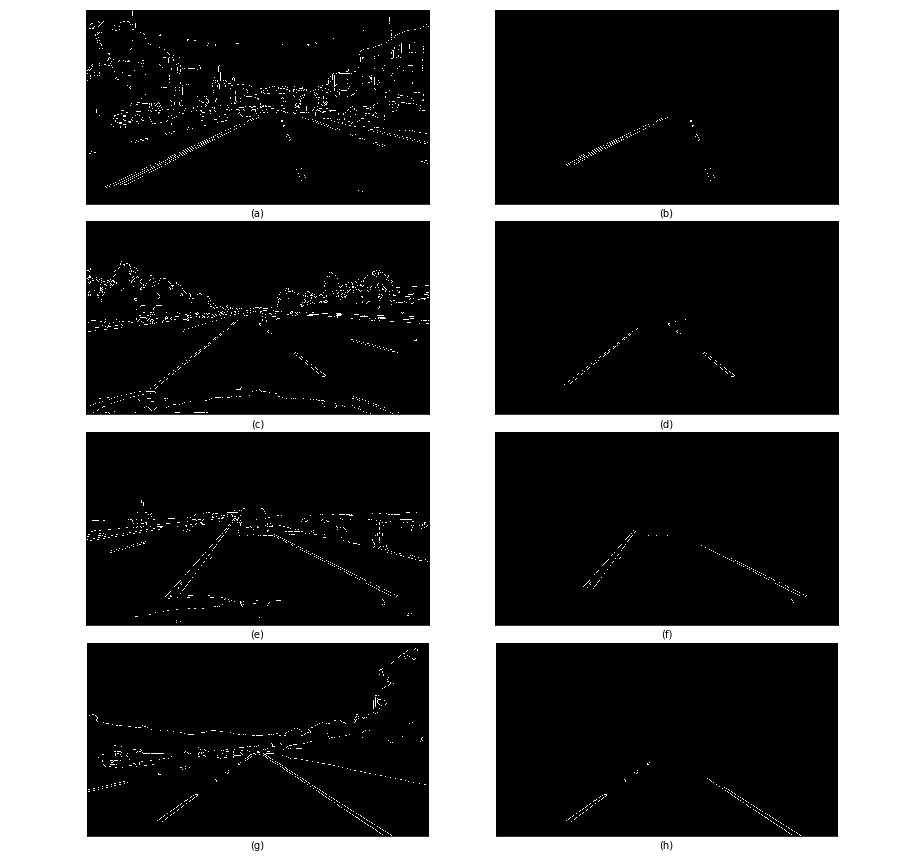

In [23]:
plot(img_seg_list, figsize=(12,12), title_loc=(-800,900), title_list=title_list, cm='gray')

### Hough Transform

In [24]:
def hough_lines(img, rho=None, theta=None, threshold=None, min_line_len=None, max_line_gap=None):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

In [25]:
houghlines_list = []
hough_para = {'rho':2, 'theta':np.pi/180, 'threshold':50, 'minLen':50, 'maxGap':50}
for im in [img_seg_list[i] for i in range(len(img_seg_list)) if i%2==1]:
    houghline = hough_lines(im.astype(np.uint8), rho=hough_para['rho'], theta=hough_para['theta'], threshold=hough_para['threshold'], min_line_len=hough_para['minLen'], max_line_gap=hough_para['maxGap'])
    houghlines_list.append(houghline)   
    

### Line Visualization

In [26]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

In [27]:
img_line_list = []
for img, lines in zip(img_list, houghlines_list):
    img_line = draw_lines(img, lines)
    img_line_list.append(img_line)

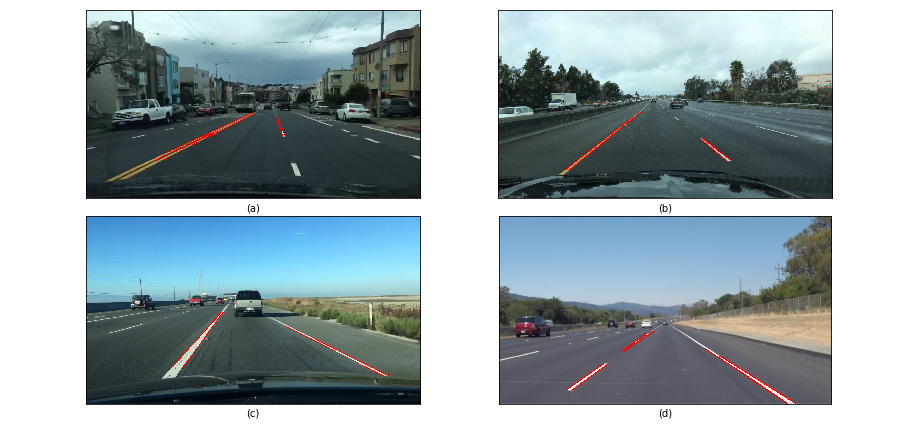

In [28]:
plot(img_line_list, figsize=(12,6), title_loc=(-800,900), title_list=title_list)

Averaging lines

slope<0 -- left lanes; slope>0 -- right lanes. Get all left lanes and right lanes, average them by weighting with line segment lengths. 

In [29]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)

Given the expression of the averaged left line and right line (slope/intercept), find the starting points (x1, y1) and end points (x2, y2) for left and right lines respectively. y corrdinates are picked such that the lane lines start from the bottom of the image y=image.shape[0] and extends to the middle of the image.

In [30]:
def make_line_points(y1, y2, line):

    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

In [31]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line

In [32]:
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)

    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    final_image = cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)
    return final_image


In [33]:
lane_images = []
for image, lines in zip(img_list, houghlines_list):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))
    

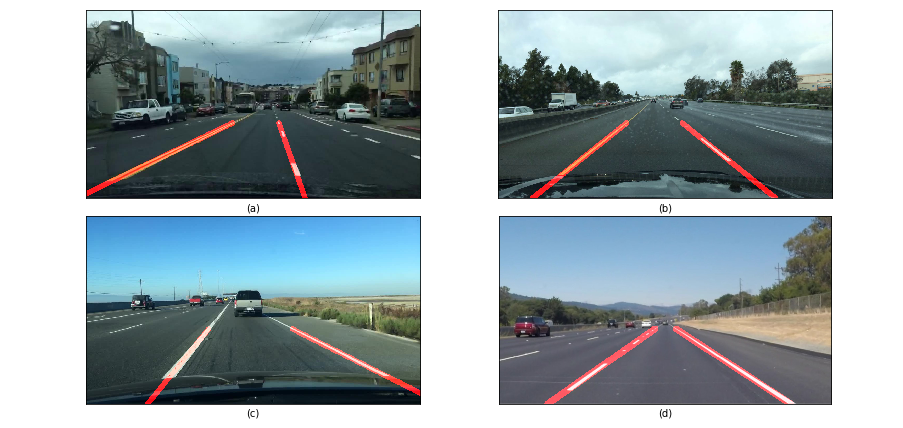

In [34]:
plot(lane_images, title_loc=(-600,900), title_list=title_list, figsize=(12,6))

### Video Processing

In [35]:
def pipeline(img):
    
    img_gray = gray_scale(img)
    row, col = img_gray.shape
    img_blur = gaussian_blur(img_gray, kernel_size, sigma)
    img_canny = canny_edge(img_blur, low_thred, high_thred)
    
    ratio = [(0.15,1),(0.5,0.55),(0.9,0.9),(0.5,0.55)]
    img_seg = select_region(img_canny, ratio)
    
    hough_para = {'rho':2, 'theta':np.pi/180, 'threshold':50, 'minLen':50, 'maxGap':50}
    img_hough = hough_lines(img_seg.astype(np.uint8), rho=hough_para['rho'], theta=hough_para['theta'], threshold=hough_para['threshold'], min_line_len=hough_para['minLen'], max_line_gap=hough_para['maxGap'])
    
    img_lanes = draw_lane_lines(img, lane_lines(img, img_hough), thickness=5)
    
    return img_lanes


In [36]:
# cap = cv2.VideoCapture('demo.mp4')

# while cap.isOpened():
#     ret, frame = cap.read()
#     lane = pipeline(frame)
#     cv2.imshow('frame', lane)
#     if cv2.waitKey(0) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [37]:
output_video = 'lane_detector.mp4'

clip = VideoFileClip(cwd + '/test_video/demo.mp4')
lane_clip = clip.fl_image(pipeline)
%time lane_clip.write_videofile(output_video, audio=False)

t:   8%|▊         | 17/221 [00:00<00:01, 167.70it/s, now=None]

Moviepy - Building video lane_detector.mp4.
Moviepy - Writing video lane_detector.mp4



Moviepy - Done !
Moviepy - video ready lane_detector.mp4
CPU times: user 1.64 s, sys: 248 ms, total: 1.89 s
Wall time: 2.41 s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))